In [2]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import models
from tensorflow.keras import utils
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

2025-12-02 15:03:31.334735: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-02 15:03:31.373855: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-02 15:03:31.373884: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-02 15:03:31.374911: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-02 15:03:31.381166: I tensorflow/core/platform/cpu_feature_guar

In [3]:
# Load MNIST to 28*28*1 (1 channel:grey) + normalize between 0 & 1
def load_mnist():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    X = x_train.astype('float32') / 255.0
    X = X.reshape(-1, 28, 28, 1)
    y = y_train.reshape(-1, 1)

    X_t = x_test.astype('float32') / 255.0
    X_t = X_t.reshape(-1, 28, 28, 1)
    y_t = y_test.reshape(-1, 1)
    
    return X,y,X_t,y_t

# https://www.kaggle.com/danbrice/keras-plot-history-full-report-and-grid-search
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_confusion_matrix(X, y_cat, model, title="", log=False):
    y_pred = model.predict(X).argmax(axis=1)
    cm = confusion_matrix(y_cat.argmax(axis=1), y_pred)
    
    plt.figure(figsize=(8,6))
    if log:
        plt.imshow(np.log1p(cm), interpolation='nearest', cmap='Blues')
    else:
        plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(f'Confusion Matrix - {title}')
    plt.colorbar()
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(100*cm[i, j] / len(y_pred), '.2f'), 
                    ha="center", va="center", color="green")
    plt.tight_layout()
    plt.show()

## Let's load the different Train & Test data

In [4]:
X,y,X_t,y_t = load_mnist()

print(f"MNIST loaded: \n\tX   {X.shape}\n\ty   {y.shape}\n\tX_t {X_t.shape}\n\ty_t {y_t.shape}")

MNIST loaded: 
	X   (60000, 28, 28, 1)
	y   (60000, 1)
	X_t (10000, 28, 28, 1)
	y_t (10000, 1)


We use MNIST dataset

 * The dataset has 70000 rows and each row has 785 columns
 * In each row the first 784 is a 28x28 pixel grayscale (0-255) image of a hand written number
 * The last number is the number on the image

Create the network

In [5]:
classifier = Sequential()

# Convolutional Layer
classifier.add(Conv2D(6, (3, 3), input_shape=(28, 28, 1), activation='relu'))
# classifier.add(MaxPooling2D(pool_size=(2, 2))) # take the max in each 2*2 window: divides size by 2*2
classifier.add(Dropout(.05)) # replace 5% of the outputs by 0 to reduce over-fitting # disabled when predicted

classifier.add(Flatten()) # Once the convolutions are done, we flatten to get an array

# Dense Hidden Layer
classifier.add(Dense(8, activation='relu'))
# classifier.add(Dropout(.10))

# Output Layer for Classification
classifier.add(Dense(10))#no softmax

classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 6)         60        
                                                                 
 dropout (Dropout)           (None, 26, 26, 6)         0         
                                                                 
 flatten (Flatten)           (None, 4056)              0         
                                                                 
 dense (Dense)               (None, 8)                 32456     
                                                                 
 dense_1 (Dense)             (None, 10)                90        
                                                                 
Total params: 32606 (127.37 KB)
Trainable params: 32606 (127.37 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
2025-12-02 15:03:3

Compile

In [6]:
classifier.compile( optimizer = 'rmsprop', 
                    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), # logits pcq plus de softmax
                    metrics = ['accuracy'])

Create categorical data (i.e [1, 2] becomes [[1, 0, 0], [0, 1, 0]])

In [7]:
y_cat = to_categorical(y)
yt_cat = to_categorical(y_t)

In [8]:
print(f"train sizes: X: {X.shape} ; y: {y_cat.shape}\ntest  sizes: X: {X_t.shape} ; y: {yt_cat.shape}")

train sizes: X: (60000, 28, 28, 1) ; y: (60000, 10)
test  sizes: X: (10000, 28, 28, 1) ; y: (10000, 10)


**Train the model**

In [9]:
history = classifier.fit(X, y_cat, batch_size=64, epochs=5, verbose=1, validation_data=(X_t, yt_cat))

Epoch 1/5
938/938 [==============================] - 5s 4ms/step - loss: 0.4642 - accuracy: 0.8690 - val_loss: 0.2242 - val_accuracy: 0.9344
Epoch 2/5
938/938 [==============================] - 4s 4ms/step - loss: 0.1988 - accuracy: 0.9434 - val_loss: 0.1424 - val_accuracy: 0.9585
Epoch 3/5
938/938 [==============================] - 4s 4ms/step - loss: 0.1401 - accuracy: 0.9598 - val_loss: 0.1142 - val_accuracy: 0.9647
Epoch 4/5
938/938 [==============================] - 4s 4ms/step - loss: 0.1119 - accuracy: 0.9679 - val_loss: 0.0951 - val_accuracy: 0.9706
Epoch 5/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0962 - accuracy: 0.9721 - val_loss: 0.0858 - val_accuracy: 0.9724


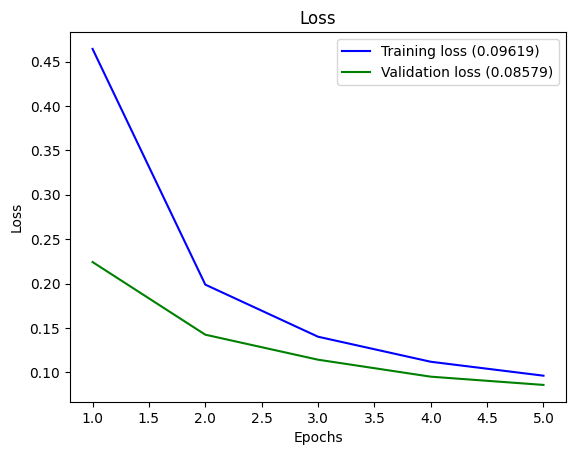

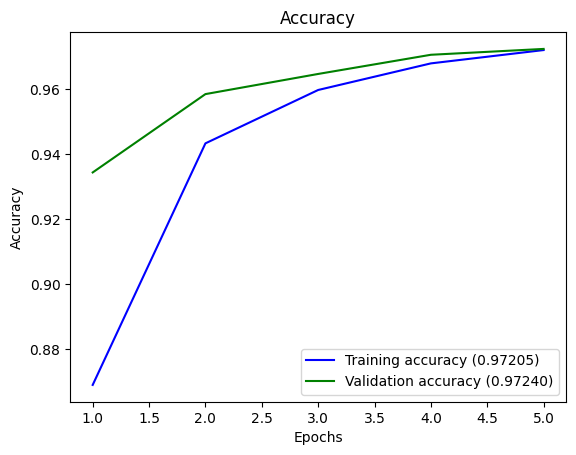

In [10]:
plot_history(history)

### Evaluate the model
Les matrices de confusions affichent les pourcentages et sont colorées de manière logarithmique

1875/1875 [==============================] - 1s 759us/step


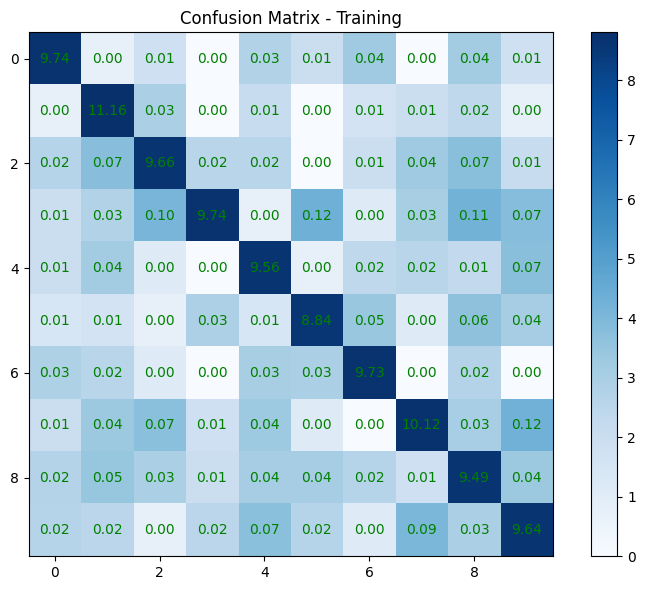

313/313 [==============================] - 0s 746us/step


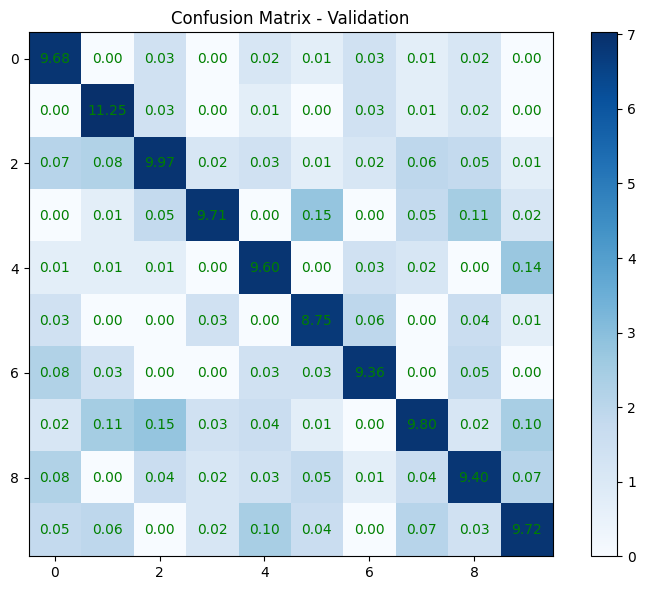

In [11]:
plot_confusion_matrix(X, y_cat, classifier, 'Training', log=True)
plot_confusion_matrix(X_t, yt_cat, classifier, 'Validation', log=True)

In [12]:
classifier.save('./mnist_classifier_model-no-softmax.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
